In [4]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
%matplotlib inline
### imports ###
import sys
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib_venn import venn3
import seaborn as sns

matplotlib.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from homer_preprocessing import import_homer_diffgene, read_homer_gene_exp, read_annotated_peaks
from plotting_scripts import plot_exp_rpkm, gene_list_bar_plot

In [5]:
workingDirectory = '/home/h1bennet/strains_rna/results/K03_Strains_CCl4toControl_Kupffer_RNA/'
amlnDirectory = '/home/h1bennet/strains/data/RNA/CCl4_6week_kupffer/'
controlDirectory = '/home/h1bennet/strains/data/RNA/control_kupffer/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

if not os.path.isdir('./figures/'):
    os.mkdir('./figures/')

To do this analysis we will pull from the differential analysis performed by Ty at the following location:  

     /home/ttroutman/strainsKupffer/rnaKupfferEnvironments/
     
Ty re-ran the analysis filtering hepatocyte biased genes that were contaminating some of our samples. These new results are stored at the following locations:
    
    /home/ttroutman/strainsKupffer/rnaKupfferEnvironments//rnaDiff
    /home/ttroutman/strainsKupffer/rnaKupfferEnvironments//rnaQuan/rawT.txt
 

In [13]:
diffDir = '/home/ttroutman/strainsKupffer/rnaKupfferEnvironments/rnaDiff/'
rnaQuan = '/home/ttroutman/strainsKupffer/rnaKupfferEnvironments/rnaQuan/rawT.txt'


# Import differential gene files for examination and plotting

Make folder for figures

In [7]:
if not os.path.isdir('./figures/'):
    os.mkdir('./figures')

## Write differential genes to list for metascape

In [8]:
if not os.path.isdir('./gene_lists/'):
    os.mkdir('./gene_lists')

In [9]:
log2fc = 1
pval = 0.05
gene_list_dict ={}

In [14]:
np.sort(glob.glob(diffDir+'/*'))

array(['/home/ttroutman/strainsKupffer/rnaKupfferEnvironments/rnaDiff/AJ_CCl4.vs.AJ_Control.scatter.pdf',
       '/home/ttroutman/strainsKupffer/rnaKupfferEnvironments/rnaDiff/AJ_CCl4.vs.AJ_Control.scatter.txt',
       '/home/ttroutman/strainsKupffer/rnaKupfferEnvironments/rnaDiff/AJ_CCl4.vs.AJ_NASH.scatter.pdf',
       '/home/ttroutman/strainsKupffer/rnaKupfferEnvironments/rnaDiff/AJ_CCl4.vs.AJ_NASH.scatter.txt',
       '/home/ttroutman/strainsKupffer/rnaKupfferEnvironments/rnaDiff/AJ_CCl4.vs.BALBcJ_CCl4.scatter.pdf',
       '/home/ttroutman/strainsKupffer/rnaKupfferEnvironments/rnaDiff/AJ_CCl4.vs.BALBcJ_CCl4.scatter.txt',
       '/home/ttroutman/strainsKupffer/rnaKupfferEnvironments/rnaDiff/AJ_CCl4.vs.BALBcJ_Control.scatter.pdf',
       '/home/ttroutman/strainsKupffer/rnaKupfferEnvironments/rnaDiff/AJ_CCl4.vs.BALBcJ_Control.scatter.txt',
       '/home/ttroutman/strainsKupffer/rnaKupfferEnvironments/rnaDiff/AJ_CCl4.vs.BALBcJ_NASH.scatter.pdf',
       '/home/ttroutman/strainsKupffer/rn

In [17]:
comps = np.concatenate(
    [np.sort(glob.glob(diffDir+'/AJ*vs*AJ*scatter.txt')),
     np.sort(glob.glob(diffDir+'/BALBcJ*vs*BALBcJ*scatter.txt')),
     np.sort(glob.glob(diffDir+'/C57BL6J*vs*C57BL6J*scatter.txt'))])

# filter NASH out of samp;e8
comps = [i for i in comps if 'NASH' not in i]

In [61]:
for i in np.sort(comps):
    print(i)
    # read in gene expression data
    df = pd.read_csv(i,
                     sep='\t',
                     index_col=0)

    # select differential genes
    # df = df.loc[~(df.chr.str.contains('chrX|chrY|ChrUn')), :]
    sig_genes = df.index[(df['padj'] < pval) & (df['log2FoldChange'] >= log2fc)].to_list()
    gene_list_dict[i.split('.')[2]+'_up'] = list(sig_genes)
    # print('union set length:', print(len(g_union)))
    # print('intersection set length:', print(len(g_intersect)))


In [62]:
for key in gene_list_dict.keys():
    print(key)
    print(len(gene_list_dict[key]), 'genes')
    with open('./gene_lists/'+key+'_kupffer_genes_fc_'+str(log2fc)+'_pval_'+str(pval)+'.txt', 'w') as f:
        f.write('Gene\n')
        for i in gene_list_dict[key]:
            f.write(i+'\n')
        f.close()

# How many AMLN induced genes are in common

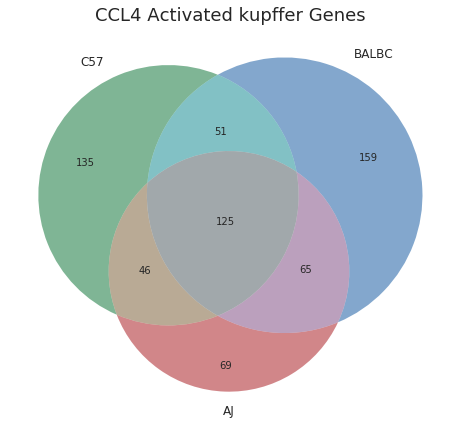

In [21]:
fig, ax = plt.subplots(figsize=(8,8))

# venn3 accepts a list with the following order
# (100, 010, 110, 001, 101, 011, 111)
# group1, group2, group1+2, group3, group1+3, group2+3, group3
venn3(subsets=[set(gene_list_dict['C57BL6J_CCl4_up']),
               set(gene_list_dict['BALBcJ_CCl4_up']),
               set(gene_list_dict['AJ_CCl4_up'])],
     ax=ax,
     set_colors=('#006d2c', '#08519c', '#a50f15'),
     set_labels=('C57', 'BALBC', 'AJ'),
     alpha=0.5)
ax.set_title('CCL4 Activated kupffer Genes');

plt.savefig('./figures/venn3_activated_genes.png', bbox_inches='tight')

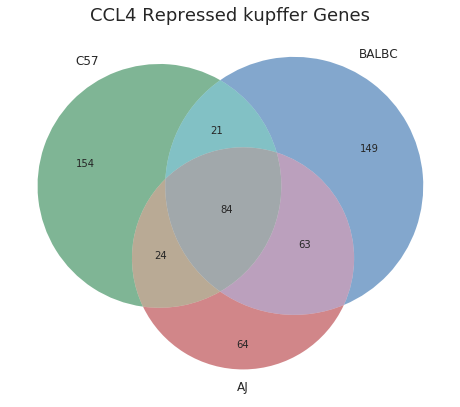

In [25]:
fig, ax = plt.subplots(figsize=(8,8))

# venn3 accepts a list with the following order
# (100, 010, 110, 001, 101, 011, 111)
# group1, group2, group1+2, group3, group1+3, group2+3, group3
venn3(subsets=[set(gene_list_dict['C57BL6J_Control_up']),
               set(gene_list_dict['BALBcJ_Control_up']),
               set(gene_list_dict['AJ_Control_up'])],
     ax=ax,
     set_colors=('#006d2c', '#08519c', '#a50f15'),
     set_labels=('C57', 'BALBC', 'AJ'),
     alpha=0.5)
ax.set_title('CCL4 Repressed kupffer Genes');

plt.savefig('./figures/venn3_repressed_genes.png', bbox_inches='tight')

### Pull sets for manual examination

activated genes

In [26]:
all3 = set(gene_list_dict['AJ_CCl4_up']).intersection(set(gene_list_dict['BALBcJ_CCl4_up']).intersection(gene_list_dict['C57BL6J_CCl4_up']))
C57_balbc = set(gene_list_dict['C57BL6J_CCl4_up']).intersection(set(gene_list_dict['BALBcJ_CCl4_up']).difference(all3))
C57_aj = set(gene_list_dict['C57BL6J_CCl4_up']).intersection(set(gene_list_dict['AJ_CCl4_up']).difference(all3))
balbc_aj = set(gene_list_dict['BALBcJ_CCl4_up']).intersection(gene_list_dict['AJ_CCl4_up']).difference(all3)
C57_private = set(gene_list_dict['C57BL6J_CCl4_up']).difference(set(all3).union(set(C57_balbc).union(C57_aj)))
balbc_private = set(gene_list_dict['BALBcJ_CCl4_up']).difference(set(all3).union(set(C57_balbc).union(balbc_aj)))
aj_private = set(gene_list_dict['AJ_CCl4_up']).difference(set(all3).union(set(C57_aj).union(balbc_aj)))

In [28]:
if not os.path.isdir('./gene_lists/'):
    os.mkdir('./gene_lists/')

In [30]:
genesets = [aj_private, balbc_private, C57_private]
genesetnames = ['aj_private', 'balbc_private', 'c57_private']
for listname, genelist in zip(genesetnames, genesets):
    with open('./gene_lists/'+listname+'_kupffer_genes_fc_'+str(log2fc)+'_pval_'+str(pval)+'.txt', 'w') as f:
        f.write('Gene\n')
        for i in genelist:
            f.write(i+'\n')
        f.close()

### How much of balb set is driven by hepatocyte contamination

We need to try and filter some of the hepatocyte specific genes, our back of the envelope filter will be any gene with hepatocyte expression > 1000 TPM and kupffer cell expression < 100 TPM

In [31]:
control_tpm = pd.read_csv(
    '/gpfs/data01/glasslab/home/h1bennet/strains_rna/results/A00_Strains_Control_WholeLiver_RNA/expression/rawT.txt',
    index_col=0,
    sep='\t')

In [32]:
kupffer_avg = control_tpm.loc[:, control_tpm.columns.str.contains('kupffer')].mean(1)
hepatocyte_avg = control_tpm.loc[:, control_tpm.columns.str.contains('hepatocyte')].mean(1)

In [33]:
abs_tpm = (hepatocyte_avg > 500) & (kupffer_avg < 50)
hep_genes = control_tpm.index[abs_tpm].tolist()

## Make scatters comparing the genes captured by these methods

In [34]:
ratio = (hepatocyte_avg / kupffer_avg > 10)
hep_genes_ratio = control_tpm.index[ratio].tolist()

Import TPM

In [35]:
print(len(hep_genes))
print(len(balbc_private.intersection(hep_genes)))
print(len(set(gene_list_dict['BALBcJ_CCl4_up']).intersection(hep_genes)))

103
0
4


In [36]:
print(len(set(hep_genes_ratio)))
print(len(set(gene_list_dict['BALBcJ_CCl4_up']).intersection(hep_genes_ratio)))
print(len(balbc_private.intersection(hep_genes_ratio)))

3041
28
7


### H3K27Ac and ATAC filtering


In [37]:
atac, atac_mat = read_annotated_peaks(
    '/gpfs/data01/glasslab/home/h1bennet/strains/results/01_Strains_AMLN_ATAC/merged_peaks/ann_promoters_atac.txt')

In [38]:
h3k27ac, h3k27ac_mat = read_annotated_peaks(
    '/gpfs/data01/glasslab/home/h1bennet/strains/results/01_Strains_AMLN_H3K27Ac/merged_peaks/ann_promoters_h3k27ac.txt')

In [39]:
h3k27ac_low = (set(h3k27ac.loc[(h3k27ac_mat.mean(1) < 16), 'Gene Name'].dropna().to_list()),
               set(h3k27ac.loc[(h3k27ac_mat.mean(1) < 32), 'Gene Name'].dropna().to_list()))
atac_low = (set(atac.loc[(atac_mat.mean(1) < 16), 'Gene Name'].dropna().to_list()),
            set(atac.loc[(atac_mat.mean(1) < 32), 'Gene Name'].dropna().to_list()))

# Plot differential peaks

In [40]:
tpm = pd.read_csv(rnaQuan,
                  index_col=0,
                  sep='\t')

Set groups

In [41]:
groups = [[[0,1],[6,7,8,9]],
          [[2,3],[10,11,12]],
          [[4,5],[13,14,15,16]]]

group_labels = [['AJ Control', 'AJ AMLN'],
                ['Balb/cJ Control', 'Balb/cJ AMLN'],
                ['C57BL/6J Control', 'C57BL/6J AMLN']]

NameError: name 'kc_low' is not defined

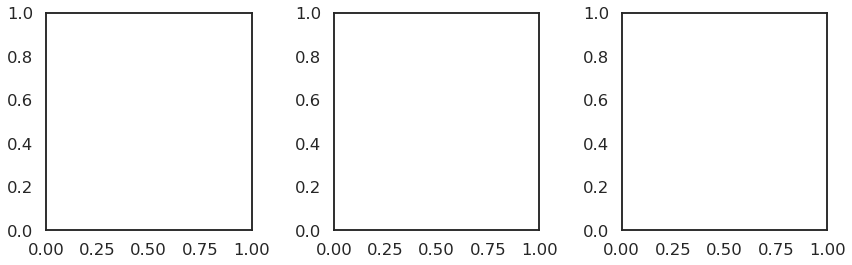

In [42]:
fig, axs = plt.subplots(1,3, figsize=(14,4))
plt.subplots_adjust(wspace=0.4)

# set target gene list
target_set = kc_low[0]
print(len(target_set), 'hepatocyte enriched genes')

for group, label, ax in zip(groups, group_labels, axs.flatten()):
    ax.scatter(np.log2(tpm.iloc[:, group[0]].mean(1)+1),
               np.log2(tpm.iloc[:, group[1]].mean(1)+1),
               c='k',
               s=0.5)
    
    ax.scatter(np.log2(tpm.iloc[:, group[0]].reindex(target_set).mean(1)+1),
               np.log2(tpm.iloc[:, group[1]].reindex(target_set).mean(1)+1),
               c='#de2d26',
               s=0.5)
    
    ax.set_xlabel(label[0])
    ax.set_ylabel(label[1])

In [ ]:
kc_low = (set(atac_low[0]).intersection(h3k27ac_low[0]),
          set(atac_low[1]).intersection(h3k27ac_low[1]))

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(14,4))
plt.subplots_adjust(wspace=0.4)

# set target gene list
target_set = kc_low[1]
print(len(target_set), 'hepatocyte enriched genes')

for group, label, ax in zip(groups, group_labels, axs.flatten()):
    ax.scatter(np.log2(tpm.iloc[:, group[0]].mean(1)+1),
               np.log2(tpm.iloc[:, group[1]].mean(1)+1),
               c='k',
               s=0.5)
    
    ax.scatter(np.log2(tpm.iloc[:, group[0]].reindex(target_set).mean(1)+1),
               np.log2(tpm.iloc[:, group[1]].reindex(target_set).mean(1)+1),
               c='#de2d26',
               s=0.5)
    
    ax.set_xlabel(label[0])
    ax.set_ylabel(label[1])

Based on these the most reasonable filters appear to be the H3K27Ac + ATAC < 16 filter or the TPM ratio filter. We will try both of these and see how the affect our downstream gene sets (check GO etc etc)

In [43]:
from matplotlib_venn import venn2

In [44]:
venn2([kc_low[0], set(hep_genes_ratio)],
      set_labels=['Epigenetic Filter',
                  'Gene expression filter'])

NameError: name 'kc_low' is not defined

### TPM Filtering

expression level

103 hepatocyte enriched genes


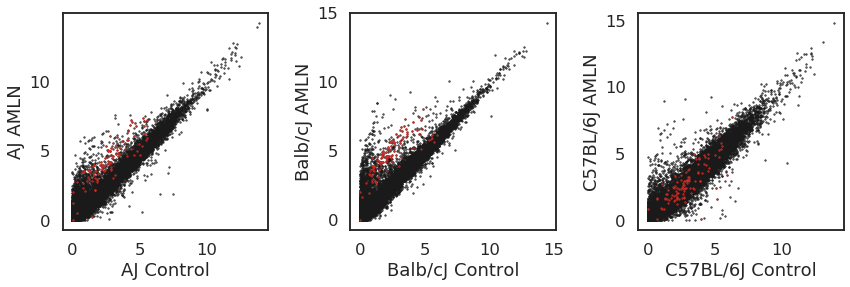

In [45]:
fig, axs = plt.subplots(1,3, figsize=(14,4))
plt.subplots_adjust(wspace=0.4)

# set filtering gene list
target_set = hep_genes
print(len(target_set), 'hepatocyte enriched genes')

for group, label, ax in zip(groups, group_labels, axs.flatten()):
    ax.scatter(np.log2(tpm.iloc[:, group[0]].mean(1)+1),
               np.log2(tpm.iloc[:, group[1]].mean(1)+1),
               c='k',
               s=0.5)
    
    ax.scatter(np.log2(tpm.iloc[:, group[0]].reindex(target_set).mean(1)+1),
               np.log2(tpm.iloc[:, group[1]].reindex(target_set).mean(1)+1),
               c='#de2d26',
               s=0.5)
    
    ax.set_xlabel(label[0])
    ax.set_ylabel(label[1])

Expression ratio

3041 hepatocyte enriched genes


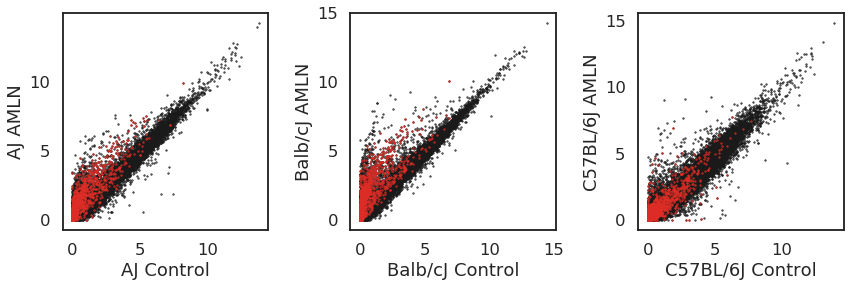

In [46]:
fig, axs = plt.subplots(1,3, figsize=(14,4))
plt.subplots_adjust(wspace=0.4)

# set filtering gene list
target_set = hep_genes_ratio
print(len(target_set), 'hepatocyte enriched genes')

for group, label, ax in zip(groups, group_labels, axs.flatten()):
    ax.scatter(np.log2(tpm.iloc[:, group[0]].mean(1)+1),
               np.log2(tpm.iloc[:, group[1]].mean(1)+1),
               c='k',
               s=0.5)
    
    ax.scatter(np.log2(tpm.iloc[:, group[0]].reindex(target_set).mean(1)+1),
               np.log2(tpm.iloc[:, group[1]].reindex(target_set).mean(1)+1),
               c='#de2d26',
               s=0.5)
    
    ax.set_xlabel(label[0])
    ax.set_ylabel(label[1])

# Plot single genes using barplot

In [65]:
tpm = pd.read_csv(rnaQuan,
                  index_col=0,
                  sep='\t')

In [67]:
for i, colname in zip(range(0, tpm.shape[1]), tpm.columns):
    print(i, colname)

0 AJ_Control_AJ01C
1 AJ_Control_AJ01D
2 BALBcJ_Control_BALB01C
3 BALBcJ_Control_BALB01D
4 C57BL6J_Control_C5701C
5 C57BL6J_Control_C5701D
6 AJ_NASH_AJ6A
7 AJ_NASH_AJ3A
8 AJ_NASH_AJ3B
9 AJ_NASH_AJ3C
10 BALBcJ_NASH_BALB3B
11 BALBcJ_NASH_BALB3C
12 BALBcJ_NASH_BALB3D
13 C57BL6J_NASH_LN144B
14 C57BL6J_NASH_LN146C
15 C57BL6J_NASH_LN146D
16 C57BL6J_NASH_LN152B
17 AJ_CCl4_AJ12A
18 AJ_CCl4_AJ12B
19 BALBcJ_CCl4_BALB12A
20 BALBcJ_CCl4_BALB13A
21 BALBcJ_CCl4_BALB13B
22 C57BL6J_CCl4_CC1B
23 C57BL6J_CCl4_CC1C
24 C57BL6J_CCl4_CC1D


In [71]:
groups = [[0,1],
          [17,18],
          [2,3],
          [19,20,21],
          [4,5],
          [22,23,24]]

group_labels = ['AJ Kupffer Control young',
                'AJ Kupffer CCL4 6 weeks',
                'Balb/cJ Kupffer Control young',
                'Balb/cJ Kupffer CCL4 6 weeks',
                'C57BL/6J Kupffer Control young',
                'C57BL/6J Kupffer CCL4 6 weeks']

colors = ['#de2d26',
          '#a50f15',
          '#6baed6',
          '#08519c',
          '#74c476',
          '#006d2c']

In [72]:
legend_elements = []
for lab, col in  zip(group_labels, colors):
    legend_elements.append(Patch(label=lab, color=col))

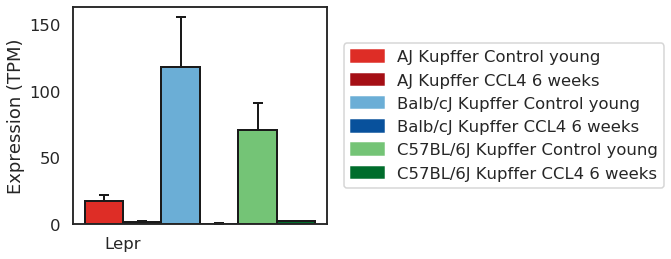

In [73]:
gene = 'Lepr'

fig, axs = plt.subplots(1, 2,
                       figsize=(10, 4))

gene_list_bar_plot([gene],
                   tpm,
                   groups=groups,
                   group_labels = group_labels,
                   colors = colors,
                   ax=axs[0])

axs[0].get_legend().remove()

axs[1].legend(handles=legend_elements, loc='center')
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['left'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)
axs[1].set_xticklabels('')
axs[1].set_yticklabels('')

plt.savefig('./figures/'+gene+'_tpm_barplot.png', bbox_inches='tight')

In [112]:
groups = [[0,1],
          [2,3],
          [4,5]]

group_labels = ['AJ Kupffer Control young',
                'Balb/cJ Kupffer Control young',
                'C57BL/6J Kupffer Control young']

colors = [''#de2d26'',
          '#6baed6',
          '#74c476']

In [113]:
legend_elements = []
for lab, col in  zip(group_labels, colors):
    legend_elements.append(Patch(label=lab, color=col))

[]

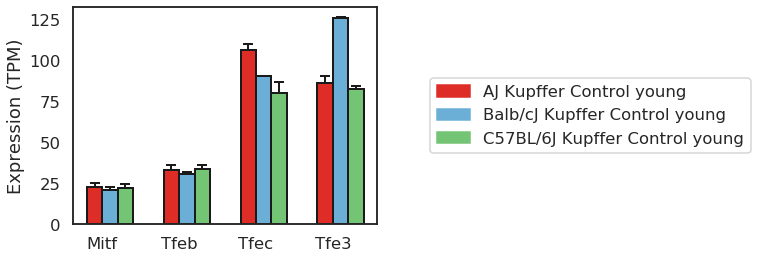

In [15]:
gene = ['Mitf', 'Tfeb', 'Tfec', 'Tfe3']

fig, axs = plt.subplots(1, 2,
                       figsize=(12, 4))

gene_list_bar_plot(gene,
                   tpm,
                   groups=groups,
                   group_labels = group_labels,
                   colors = colors,
                   width=0.2, 
                   ax=axs[0])

axs[0].get_legend().remove()

axs[1].legend(handles=legend_elements, loc='center')
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['left'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)
axs[1].set_xticklabels('')
axs[1].set_yticklabels('')